<a href="https://colab.research.google.com/github/kyubin-l/urop/blob/main/intermediate_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Layers 

The intermediate outputs of the test dataset is studied in this script. Signal processing tools (functions) in mcoherence.py is used in this script. 

In [2]:
# Connect to Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Adjust file path accordingly
import os
os.chdir('/content/gdrive/MyDrive/urop_copy')
os.getcwd()

'/content/gdrive/MyDrive/urop_copy'

In [4]:
# Import packages
import tensorflow as tf
import numpy as np
import math
from scipy.io import loadmat
import matplotlib.pyplot as plt


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Softmax, Conv1D, Add

In [5]:
# Running python files with functions

%run './CNNfunctions.py'
%run './mcoherence.py'

# Importing Model

In [6]:
model = load_model('./saved_models/model1_s_4/')

In [7]:
input = model.input
layers = model.layers # All layers

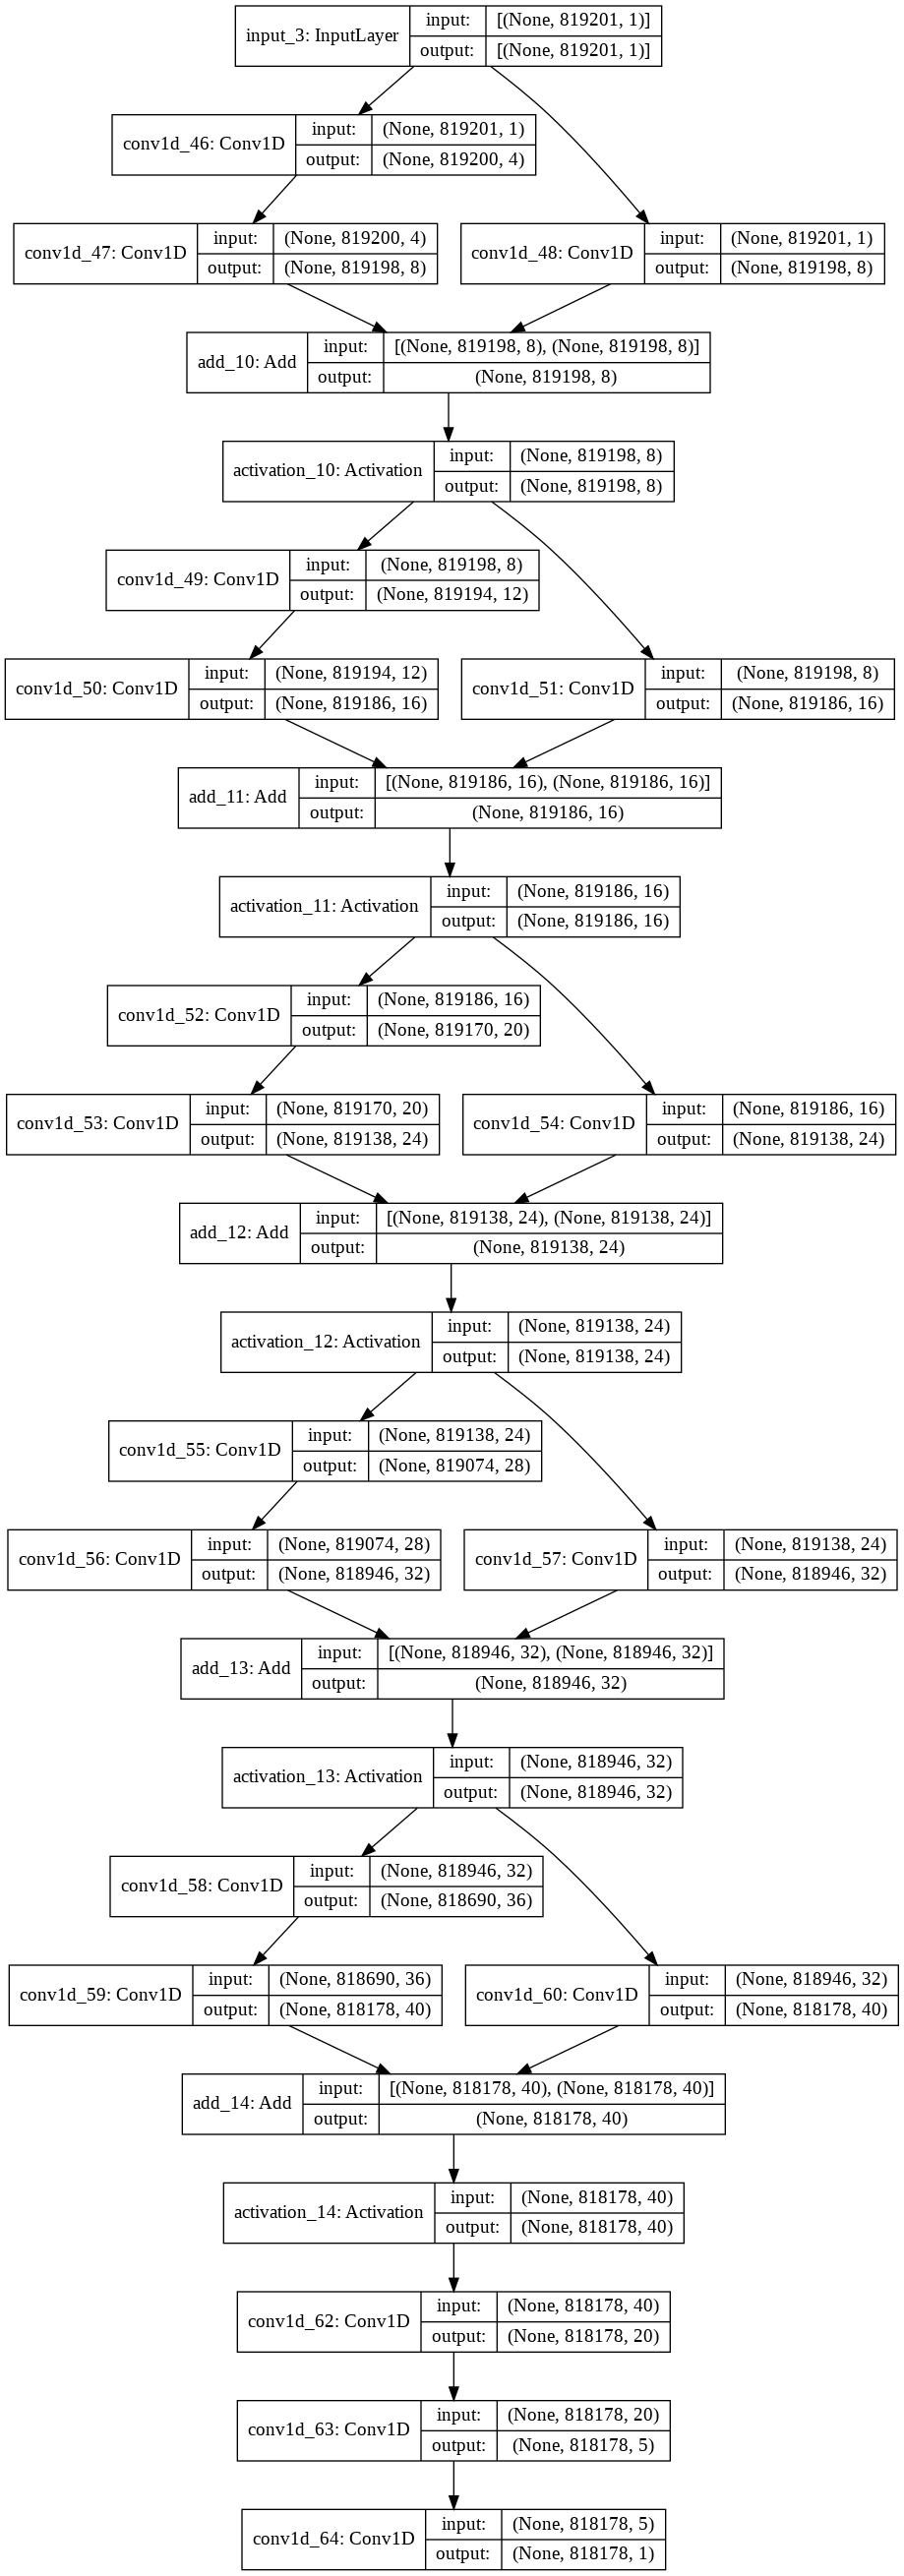

In [8]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

In [9]:
# Defining a new model with all the intermediate layer outputs as an output
layer_outputs = [layer.output for layer in layers]
intermediate_outputs = Model(inputs=input, outputs=layer_outputs)

In [10]:
# This shows all the different outputs and the shape of the new model
layer_outputs

[<KerasTensor: shape=(None, 819201, 1) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 819200, 4) dtype=float32 (created by layer 'conv1d_46')>,
 <KerasTensor: shape=(None, 819198, 8) dtype=float32 (created by layer 'conv1d_47')>,
 <KerasTensor: shape=(None, 819198, 8) dtype=float32 (created by layer 'conv1d_48')>,
 <KerasTensor: shape=(None, 819198, 8) dtype=float32 (created by layer 'add_10')>,
 <KerasTensor: shape=(None, 819198, 8) dtype=float32 (created by layer 'activation_10')>,
 <KerasTensor: shape=(None, 819194, 12) dtype=float32 (created by layer 'conv1d_49')>,
 <KerasTensor: shape=(None, 819186, 16) dtype=float32 (created by layer 'conv1d_50')>,
 <KerasTensor: shape=(None, 819186, 16) dtype=float32 (created by layer 'conv1d_51')>,
 <KerasTensor: shape=(None, 819186, 16) dtype=float32 (created by layer 'add_11')>,
 <KerasTensor: shape=(None, 819186, 16) dtype=float32 (created by layer 'activation_11')>,
 <KerasTensor: shape=(None, 819170, 20) dtype=flo

# Loading Data

In [11]:
def LoadData(file_numbers, stem, receptive_field):

  for f in range(len(file_numbers)):

    filepath = '%(stem)s%(file_number)i.mat' % {"stem": stem, "file_number": file_numbers[f]}
    data = loadmat(filepath)

    y = data['x']
    x = data['F']

    if f == 0:
      inputs = x[np.newaxis,:,:]
      outputs = y[np.newaxis,receptive_field-1:,0]

    else:
      inputs = np.concatenate((inputs, x[np.newaxis,:,:]), axis=0)
      outputs = np.concatenate((outputs, y[np.newaxis,receptive_field-1:,0]), axis=0)

  inputs = tf.constant(inputs, dtype='float32')
  outputs = tf.constant(outputs, dtype='float32')

  return inputs, outputs

In [12]:
# Ensure that these parameters are modified according to how the model was trained

Data = {'stem' : './duffing_data/white_noise/nonlinear_stiffness_',
        'train_files' : [1,3,4,6,7,9,11,12,14,17,18],#list(range(1,5)),
        'test_files' : [2,8,13,16,19],
        'val_files' : [5,10,15,20], 
        'model_save_path' : './saved_models/l11_k3_c4_tanh',
        'sampling_frequency' : 4096}  # 2**12

Hpar = {'layers' : 11,
        'skips' : 1,
        'activation' : 'tanh',
        'kernel_width' :2}

if Hpar['skips'] == 2:
  Hpar['receptive_field'] = Hpar['kernel_width']**(math.floor(Hpar['layers']/2)+1) - 1
else:
  Hpar['receptive_field'] = Hpar['kernel_width']**(Hpar['layers']-1)


Opt = {'window_length' : 2**13,
       'freq_range' : np.array([1,200]),
       'learning_rate' : 0.005,
       'num_epochs' : 100,
       'causality' : 1000,
       'batch_size' : 2} 
    
Opt['freq_ind'] = np.rint(Opt['freq_range'] / (Data['sampling_frequency'] / Opt['window_length'])).astype(int)

In [13]:
test_inputs, test_outputs = LoadData(Data['test_files'], Data['stem'], Hpar['receptive_field'])

In [14]:
# Taking a sample intput and output for analysing
test_in = test_inputs[3].numpy()
test_in = test_in[np.newaxis, ...] # intput shape should be in form (1, 819201, 1)

test_out = test_outputs[3].numpy() # output shape in form (818178,)

# Multiple Coherence

In [15]:
# Extracting all intermediate outputs of the model according to a sample test intput. Gives all outputs in a list
int_outputs = intermediate_outputs(test_in)

In [24]:
int_outputs[0].shape

TensorShape([1, 819201, 1])

In [16]:
# This function modifies the shape of the intermediate outputs and returns the multiple coherence using the tfest function from the mcoherence.py script. 
def MultipleCoherence(int_outputs, test_out, layer):
    # Creating numpy array (without first dimension) of the corresponding intermediate output
    intermediate_output = int_outputs[layer].numpy()[0]

    # Adjusting intermediate output dimensions to match dimensions of the actual output (as a result of no additional padding being added with the convolutions)
    output_length = test_out.shape[0]
    intermediate_output_length = intermediate_output.shape[0]
    n = output_length - intermediate_output_length + Hpar['receptive_field']
    intermediate_output = intermediate_output[Hpar['receptive_field']-n:, :]

    # Using tfest function to calculate multiple coherence
    f, tyx, mcyx, syx, sxx, syy = tfest(inputs=intermediate_output, 
                                    outputs=test_out,
                                    win='hann',  
                                    noverlap=int(Opt['window_length']/2), 
                                    nperseg=Opt['window_length'],
                                    Fs=Data['sampling_frequency'])
    
    label = 'mCyx Layer: ' + str(layer)
    
    # PlotCoherence(f, mcyx[:,0,:], Opt['freq_range'], legend=[label])
    # Returning the multiple coherence, frequency axis and the input and output power spectra
    return mcyx, f, sxx, syy

In [ ]:
# Function which plots all the multiple coherence in a single plot
def PlotMultipleCoherence(int_outputs, test_out, layers, legend=None):
    '''
    int_outputs should be a list of all the outputs of the network, as a 
    tensorflow tensor with the shape [1, output_size, 1].

    test_out is the actual output from the data, with the shape (818178,)

    layers should be a list of integers of the layer outputs you want. The integers
    should correspond to the index in the layer_outputs list. 
    '''

    mcoh = []
    for i in layers:
        mcyx, f, sxx, syy = MultipleCoherence(int_outputs, test_out, i)
        mcoh.append(mcyx)
    
    # A custom legend can be inputed into the function, or an automatic legend will be created
    # which is equivalent to the output layer

    if legend == None:
        legend = ['L:'+str(layer) for layer in layers] 

    mcoh = np.vstack(mcoh)
    plt.plot(f, mcoh[:,0,:].transpose())
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Coherence')
    plt.ylim([0, 1])
    plt.xlim([1, 200])
    plt.legend(legend)
    plt.show()
    return mcoh

Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence


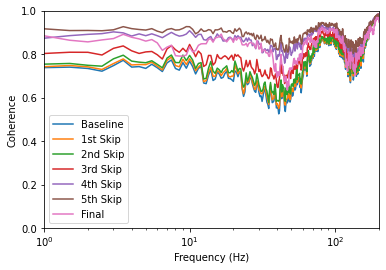

In [ ]:
mcoh = PlotMultipleCoherence(int_outputs, test_out, [0, 5, 10, 15, 20, 25, 28], ['Baseline', '1st Skip', '2nd Skip', '3rd Skip', '4th Skip', '5th Skip', 'Final'])

Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence
Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence


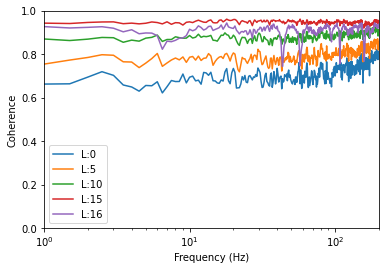

In [ ]:
mcoh = PlotMultipleCoherence(int_outputs, test_out, [0, 5, 10, 15, 16])

# Single Coherence

In [ ]:
y = model(test_in)

In [ ]:
def PlotFeatures(feature, test_output):
    '''
    This function plots the individial coherences of a given series of inputs 
    an output. It does not take the receptive field into account, so the feature
    must be modified accordingly to the receptive field 
    '''
    num_features = feature.shape[2]
    coherence = []
    labels = []
    for i in range(num_features):
        Cyx, faxis = Coherence(feature[0,:,i][...,np.newaxis], test_output, Opt['window_length'], Data['sampling_frequency'])
        coherence.append(Cyx)
        labels.append('F' + str(i+1))
    Cyx = np.concatenate(coherence, axis=0)
    PlotCoherence(faxis, Cyx, Opt['freq_range'], labels)

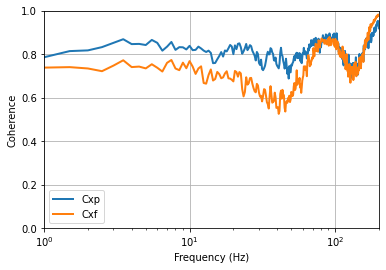

In [ ]:
# Plotting the final output coherence using the existing Coherence and PlotCoherence functions
Cyx, faxis = Coherence(y[0,:,:], test_out, Opt['window_length'], Data['sampling_frequency'])
Cyx_initial, faxis = Coherence(test_in[0][Hpar['receptive_field']-1:], test_out, Opt['window_length'], Data['sampling_frequency'])
PlotCoherence(faxis, np.vstack((Cyx, Cyx_initial)), Opt['freq_range'], ['Cxp', 'Cxf'])

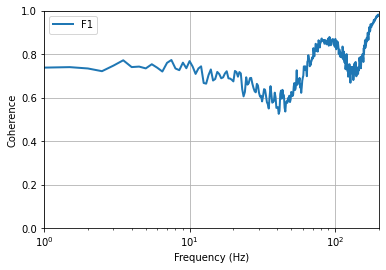

In [ ]:
# Initial coherence with the PlotFeatures function
# The index which goes into int_outputs[] is the layer from which the coherences
# are calculated. The index should match the index of layer_outputs
PlotFeatures(int_outputs[0].numpy()[:, Hpar['receptive_field']-1:, :], test_out)

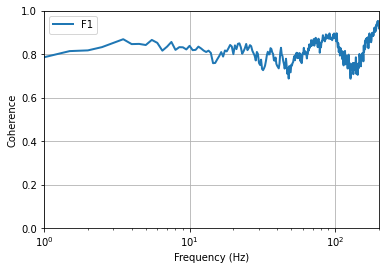

In [ ]:
PlotFeatures(int_outputs[26].numpy()[:, :, :], test_out)

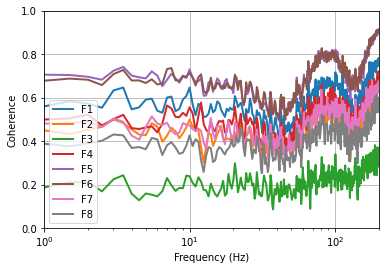

In [ ]:
PlotFeatures(int_outputs[5].numpy()[:, Hpar['receptive_field']-4:, :], test_out)

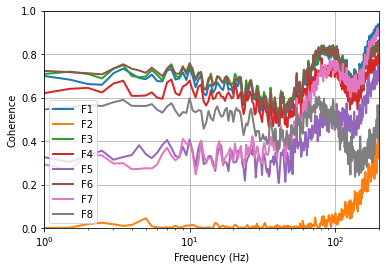

In [ ]:
PlotFeatures(int_outputs[10].numpy()[:, Hpar['receptive_field']-16:, :8], test_out)

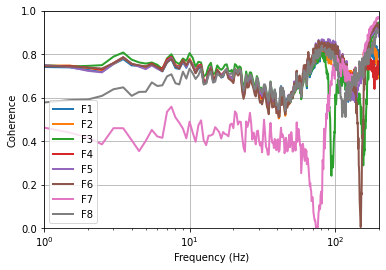

In [ ]:
PlotFeatures(int_outputs[15].numpy()[:, Hpar['receptive_field']-64:, :8], test_out)

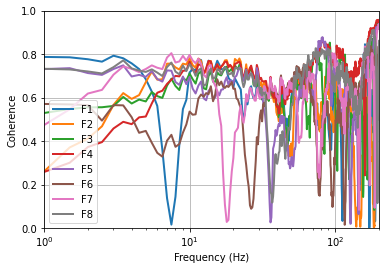

In [ ]:
PlotFeatures(int_outputs[20].numpy()[:, Hpar['receptive_field']-258:, 0:8], test_out)

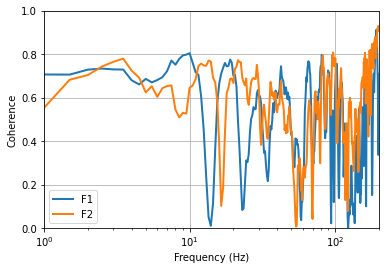

In [ ]:
PlotFeatures(int_outputs[25].numpy()[:, :, 0:2], test_out)

# Gradients

An attempt at extracting the gradients (of coherence) which respect to the weight, for each frequency value. The first function does not work and returns None (not sure why), and the second function works but is extremely slow, and does not manage to return all the gradients (runs out of ram). Most likely something related to the tape.jacobian function

In [ ]:
# Defining new tf function which stores the gradients
# Same function as the one defined in the CNNfunctions.py. 

@tf.function
def grad(model, inputs, targets, Opt):
  with tf.GradientTape() as tape:
      tape.watch(inputs)
      tape.watch(targets)
      loss, Cpy_avg, Cpy, Tpy = CoherenceLoss(model, inputs, targets, Opt)
  return tape.jacobian(tf.cast(loss[..., np.newaxis], dtype = tf.float32), tf.cast(model.trainable_variables[0], dtype = tf.float32)), loss

In [ ]:
gradient, loss = grad(model, test_in, test_out[np.newaxis, ...], Opt)

In [ ]:
type(gradient) # Returns none

NoneType

In [ ]:
@tf.function
def grad(model, x, y, Opt):
    with tf.GradientTape() as tape:
        '''
        Same function as above but the CoherenceLoss function is written out 
        manually, and different variables are told to watch as the calculations 
        are carried out. Watching the different values does not play a role 
        (all commented out now). This function does return what is wanted but 
        takes a lot of time and does not manage to compute all gradients. 
        '''



        # x = tf.Variable(x)
        # y = tf.Variable(y)
        # tape.watch(x)
        # tape.watch(y)
        # tape.watch(model.variables)

        # Extract parameters from Opt dictionary
        freq_ind = Opt['freq_ind']
        window_length = Opt['window_length']

        # Calculate model prediction for current frame(s)
        ypred = model(x)

        # tape.watch(ypred)

        # Calculate stft of y and ypred
        Y = stft(y,frame_length=window_length,frame_step=int(window_length/2),window_fn=tf.signal.hann_window)
        Ypred = stft(ypred[:,:,0],frame_length=window_length,frame_step=int(window_length/2),window_fn=tf.signal.hann_window)

        # tape.watch(Y)
        # tape.watch(Ypred)

        # Calculate average spectra over all batches
        Syy = tf.reduce_sum(Y * tf.math.conj(Y), axis=[0,1])
        Spp = tf.reduce_sum(Ypred * tf.math.conj(Ypred), axis=[0,1])
        Spy = tf.reduce_sum(Ypred * tf.math.conj(Y), axis=[0,1])

        # tape.watch(Syy)
        # tape.watch(Spp)
        # tape.watch(Spy)

        # Calculate coherence
        Cpy = tf.math.square(tf.math.abs(Spy)) / tf.cast(Spp*Syy,tf.float32)
        Cpy_avg = tf.reduce_mean(Cpy[freq_ind[0]:freq_ind[1]])

        # Cpy = tf.Variable(Cpy)

        # Loss as vector
        # loss = 1-Cpy[freq_ind[0]:freq_ind[1]]# + Opt['causality']*sum_positive_phase

        # Cpy_grads=[]
        # for i in range(freq_ind[0], freq_ind[1]):
        #     Cpy_grads.append(tape.gradient(Cpy[i], model.trainable_variables))


        return tape.jacobian(Cpy[2:400], model.trainable_variables[0]), Cpy, Cpy_avg

In [ ]:
# Cpy_grad, Cpy, Cpy_avg, loss = grad(model, test_in, test_out[np.newaxis, ...], Opt)

gradient, Cpy, Cpy_avg = grad(model, test_in, test_out[np.newaxis, ...], Opt)

In [ ]:
gradient

<tf.Tensor: shape=(8, 2, 1, 4), dtype=float32, numpy=
array([[[[-6.2289331e-03,  5.2000424e-03, -8.7606683e-03,
          -5.9671137e-03]],

        [[-1.4772345e-03, -2.8101359e-02,  1.0021994e-02,
           3.1741939e-02]]],


       [[[ 1.3419122e-03,  5.9084389e-03, -3.0505463e-02,
          -5.3714588e-03]],

        [[-2.7949121e-03, -2.9627884e-02,  3.5788614e-02,
           2.9448573e-02]]],


       [[[-4.4982950e-03,  4.1180952e-03,  1.3448453e-02,
          -3.4799259e-03]],

        [[-3.6692573e-03, -1.7522056e-02, -1.6189903e-02,
           1.3254898e-02]]],


       [[[ 1.5024161e-03, -3.8513518e-03,  2.9530594e-02,
           3.8791304e-03]],

        [[-1.8677746e-03,  2.1700952e-02, -3.6471017e-02,
          -2.3011222e-02]]],


       [[[ 1.7248997e-03, -6.5865731e-03,  1.7412446e-02,
           6.1744936e-03]],

        [[-2.1248935e-03,  3.8862146e-02, -2.1507069e-02,
          -3.8546719e-02]]],


       [[[ 9.4715944e-03,  9.6531003e-05,  7.5595290e-03,
        

In [ ]:
# Some testing with tape.gradient

x = tf.constant([[0, 1, 2], [3, 4, 5]], dtype='float32')
a = tf.constant([10, 20, 30], dtype='float32')

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x*a
dydx = tape.gradient(y, x)

In [ ]:
dydx

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[10., 20., 30.],
       [10., 20., 30.]], dtype=float32)>

In [ ]:
x = tf.constant([[0, 1, 2], [3, 4, 5]], dtype='float32')
a = tf.constant([10, 20, 30], dtype='float32')
x*a

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  0.,  20.,  60.],
       [ 30.,  80., 150.]], dtype=float32)>

In [ ]:
dydx

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 2., 4.], dtype=float32)>

# Weight and Biases

An attempt at plotting the weights of the network in a nice way. Currently this script extracts all weights but could not find a good way at plotting all these. 

In [ ]:
conv_layers = [layer for layer in layers if 'conv1d' in layer.name] # all conv layers to study weights & biases
weights = [layer.weights[0].numpy() for layer in conv_layers]
# biases = [layer.weights[1].numpy() for layer in conv_layers]

In [ ]:
# Creating one generalized weight for entire network
# Length would be equal to the receptive field of the network

l = Hpar['receptive_field']

In [ ]:
for weight in weights:
    print(weight.shape)

(2, 1, 4)
(2, 4, 8)
(2, 8, 12)
(2, 12, 16)
(2, 16, 20)
(2, 20, 24)
(2, 24, 28)
(2, 28, 32)
(2, 32, 36)
(2, 36, 40)
(1, 40, 1)


In [ ]:
w1 = weights[0]

In [ ]:
x = np.zeros(w1[0].shape)

In [ ]:
x = x[np.newaxis, ...]

In [ ]:
x.shape
x = np.tile(x, (4, 1, 1))

In [ ]:
x[0] = w1[0]
x[2] = w1[1]

In [ ]:
w1

array([[[ 0.20007452, -0.2359243 ,  1.5857184 ,  0.19754586]],

       [[-1.3139136 ,  0.60023445,  0.8642209 ,  0.41053712]]],
      dtype=float32)

In [ ]:
x.shape

(4, 1, 4)

In [ ]:
w1 = weights[0]
w1 = np.tile(w1, (512, 1, 1))

In [ ]:
updated_weights = []
for n, weight in enumerate(weights):

    if n != len(weights) - 1:
        dil = 2**n
        ker = dil*2
        # Creating dummy matrix 
        x = np.zeros(weight[0].shape)
        x = x[np.newaxis, ...]
        x = np.tile(x, (ker, 1, 1))


        x[0] = weight[0]
        x[dil] = weight[1]
        
        new_weight = np.tile(x, (int(l/ker), 1, 1))
        updated_weights.append(new_weight)
    
    else:
        new_weight = np.tile(weight, (l, 1, 1))
        updated_weights.append(new_weight)

In [ ]:
for weight in updated_weights:
    print(weight.shape)

(1024, 1, 4)
(1024, 4, 8)
(1024, 8, 12)
(1024, 12, 16)
(1024, 16, 20)
(1024, 20, 24)
(1024, 24, 28)
(1024, 28, 32)
(1024, 32, 36)
(1024, 36, 40)
(1024, 40, 1)


In [ ]:
w1 = updated_weights[0]
w2 = updated_weights[1]

W = np.einsum('ijk, ikl->ijl', w1, w2)

In [ ]:
M = np.matmul(w1, w2)

In [ ]:
W

In [ ]:
W.shape

(1024, 1, 1024, 8)

In [ ]:
for n in range(len(updated_weights) - 1):
    if n == 0:
        W = np.matmul(updated_weights[0], updated_weights[1])
    else:
        W = np.matmul(W, updated_weights[n + 1])

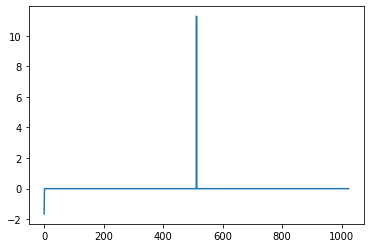

In [ ]:
plt.plot(W[:,0,0])